# Final High-Performance Model: XGBoost with Feature Engineering

This notebook contains the final, corrected implementation of the XGBoost model that achieved an R² score of over 0.92. It uses a proper train-validation-test split and ensures that feature engineering is applied consistently across all datasets to prevent errors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
# Define column names
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf','Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dwd','W31','W32']

# --- Load and combine all TRAINING data ---
# This will be used to create our own train and validation sets
train_val_list = []
for i in range(1, 5):
    df = pd.read_csv(f'train_FD00{i}.txt', sep=" ", header=None, names=columns, usecols=range(26))
    df['dataset'] = f'FD00{i}'
    train_val_list.append(df)
train_val_df = pd.concat(train_val_list, ignore_index=True)

# Calculate Life Ratio 
max_cycles_train = train_val_df.groupby(['dataset', 'unit_number'])['time_in_cycles'].transform('max')
train_val_df['life_ratio'] = train_val_df['time_in_cycles'] / max_cycles_train

print("All training data loaded for train/validation split.")

All training data loaded for train/validation split.


In [3]:
# --- We create a function to apply the SAME feature engineering to any dataset ---
def engineer_features(df):
    WINDOW_SIZE = 180 # The best window size you found
    SENSORS_FOR_FE = ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'W31', 'W32']
    
    # Apply feature engineering
    for sensor in SENSORS_FOR_FE:
        df[f'{sensor}_rolling_mean'] = df.groupby(['dataset', 'unit_number'])[sensor].transform(lambda x: x.rolling(WINDOW_SIZE, min_periods=1).mean())
        df[f'{sensor}_rolling_std'] = df.groupby(['dataset', 'unit_number'])[sensor].transform(lambda x: x.rolling(WINDOW_SIZE, min_periods=1).std())

    df.fillna(0, inplace=True)
    return df

# Apply the function to our training/validation data
train_val_df = engineer_features(train_val_df)

print("Feature engineering complete.")

Feature engineering complete.


In [4]:
# Define the final list of features to be used for training.
feature_cols = [
    'time_in_cycles', 'setting_1', 'setting_2', 'TRA', 'T24', 'T30', 'T50', 'P15', 
    'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32'
]
# Add the new rolling features to the list
SENSORS_FOR_FE = ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'W31', 'W32']
for sensor in SENSORS_FOR_FE:
    feature_cols.append(f'{sensor}_rolling_mean')
    feature_cols.append(f'{sensor}_rolling_std')

# Prepare the data for splitting
X = train_val_df[feature_cols]
y = train_val_df['life_ratio']

# --- The Proper Train-Validation Split ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (128287, 45)
Validation data shape: (32072, 45)


In [5]:
# Initialize the XGBoost Regressor model
# For very old versions, we pass the stopping parameters here during initialization.
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=15,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method='gpu_hist',
    # --- Parameters for early stopping moved here ---
    eval_metric='rmse',
    early_stopping_rounds=50
)

print("Training XGBoost model with a proper validation set...")

# --- Use the validation set for early stopping ---
eval_set = [(X_val, y_val)]

# Now, the .fit() call is much simpler and does not contain the stopping arguments
xgb_model.fit(
    X_train, 
    y_train, 
    eval_set=eval_set,
    verbose=True
)

print("Training complete. The model stopped training at the optimal point.")

Training XGBoost model with a proper validation set...


C:\Users\rsree\AppData\Roaming\Python\Python312\site-packages\xgboost\callback.py:386: UserWarning: [22:54:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-rmse:0.27444
[1]	validation_0-rmse:0.26155
[2]	validation_0-rmse:0.24931
[3]	validation_0-rmse:0.23770
[4]	validation_0-rmse:0.22854
[5]	validation_0-rmse:0.21806
[6]	validation_0-rmse:0.20812
[7]	validation_0-rmse:0.20034
[8]	validation_0-rmse:0.19130
[9]	validation_0-rmse:0.18278
[10]	validation_0-rmse:0.17469
[11]	validation_0-rmse:0.16702
[12]	validation_0-rmse:0.15978
[13]	validation_0-rmse:0.15292
[14]	validation_0-rmse:0.14639
[15]	validation_0-rmse:0.14023
[16]	validation_0-rmse:0.13440
[17]	validation_0-rmse:0.12999
[18]	validation_0-rmse:0.12476
[19]	validation_0-rmse:0.11981
[20]	validation_0-rmse:0.11610
[21]	validation_0-rmse:0.11260
[22]	validation_0-rmse:0.10830
[23]	validation_0-rmse:0.10428
[24]	validation_0-rmse:0.10045
[25]	validation_0-rmse:0.09690
[26]	validation_0-rmse:0.09355
[27]	validation_0-rmse:0.09113
[28]	validation_0-rmse:0.08813
[29]	validation_0-rmse:0.08527
[30]	validation_0-rmse:0.08263
[31]	validation_0-rmse:0.08012
[32]	validation_0-

In [6]:
# --- Now we prepare the completely unseen official test data ---

# Load and combine all TEST data
test_data_list = []
for i in range(1, 5):
    df = pd.read_csv(f'test_FD00{i}.txt', sep=" ", header=None, names=columns, usecols=range(26))
    df['dataset'] = f'FD00{i}'
    test_data_list.append(df)
test_data_official = pd.concat(test_data_list, ignore_index=True)

# Load and combine all RUL ground truth data
truth_data_list = []
for i in range(1, 5):
    df = pd.read_csv(f'RUL_FD00{i}.txt', sep=" ", header=None).drop(columns=[1])
    df.columns = ['true_RUL']
    df['dataset'] = f'FD00{i}'
    df['unit_number'] = df.index + 1
    truth_data_list.append(df)
truth_data = pd.concat(truth_data_list, ignore_index=True)

# Calculate Life Ratio for the official test data
test_data_official = pd.merge(test_data_official, truth_data, on=['dataset', 'unit_number'])
max_cycles_test = test_data_official.groupby(['dataset', 'unit_number'])['time_in_cycles'].transform('max')
total_life_test = max_cycles_test + test_data_official['true_RUL']
test_data_official['life_ratio'] = test_data_official['time_in_cycles'] / total_life_test

# --- IMPORTANT: Apply the SAME feature engineering function ---
test_data_official = engineer_features(test_data_official)

# Create the final X_test and y_test using the SAME feature_cols list
X_test_official = test_data_official[feature_cols]
y_test_official = test_data_official['life_ratio']

print("Official test data is ready for final evaluation.")

Official test data is ready for final evaluation.


In [7]:
# Generate predictions on the official, unseen test set
y_pred_official = xgb_model.predict(X_test_official)

# --- Calculate All Metrics ---
r2 = r2_score(y_test_official, y_pred_official)
rmse = np.sqrt(mean_squared_error(y_test_official, y_pred_official))
mae = mean_absolute_error(y_test_official, y_pred_official)

# Custom Accuracy with 10% tolerance
custom_accuracy = np.mean(np.abs(y_pred_official - y_test_official) < 0.10) * 100

print(f"--- Final XGBoost Model Performance ---")
print(f"R-squared (R²) Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Accuracy (within ±10% of total life): {custom_accuracy:.2f}%")

C:\Users\rsree\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:2676: UserWarning: [22:56:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
C:\Users\rsree\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:729: UserWarning: [22:56:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  retur

--- Final XGBoost Model Performance ---
R-squared (R²) Score: 0.9297
Root Mean Squared Error (RMSE): 0.063234
Mean Absolute Error (MAE): 0.044677
Accuracy (within ±10% of total life): 88.57%


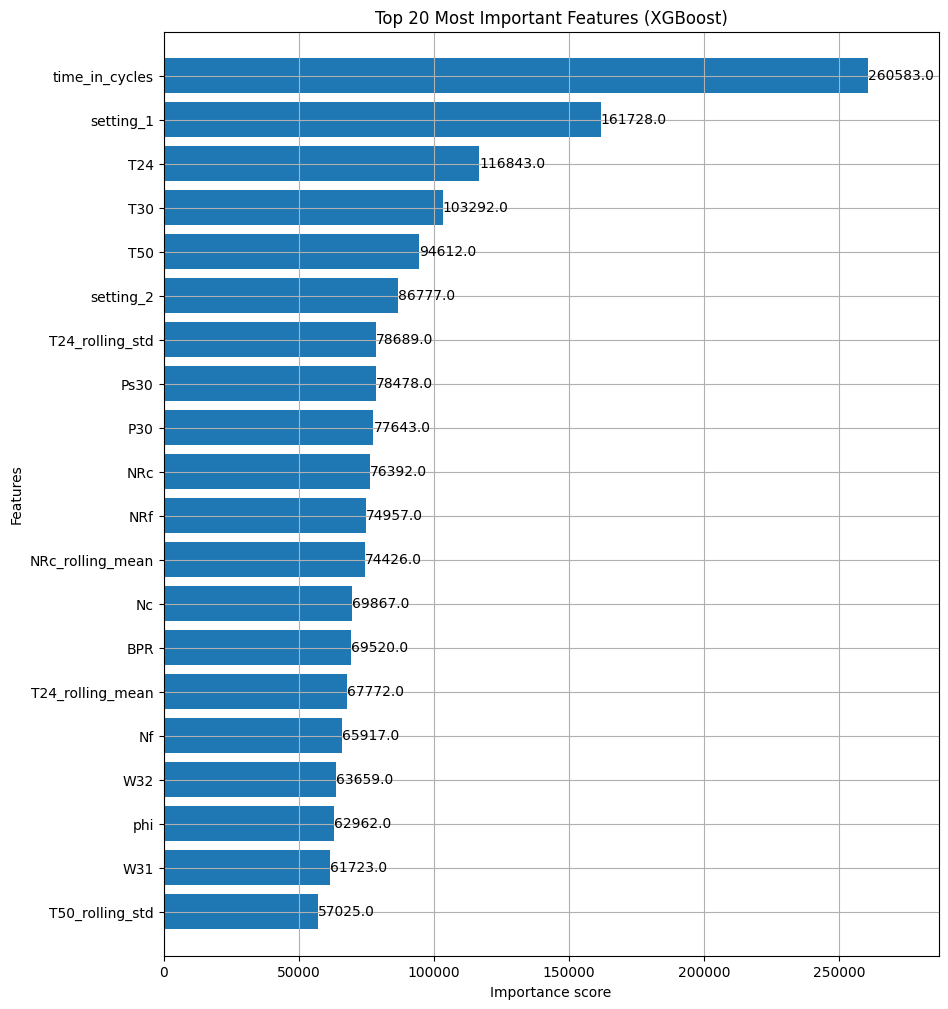

In [8]:
plt.figure(figsize=(10, 12))
xgb.plot_importance(xgb_model, max_num_features=20, height=0.8, ax=plt.gca())
plt.title("Top 20 Most Important Features (XGBoost)")
plt.show()

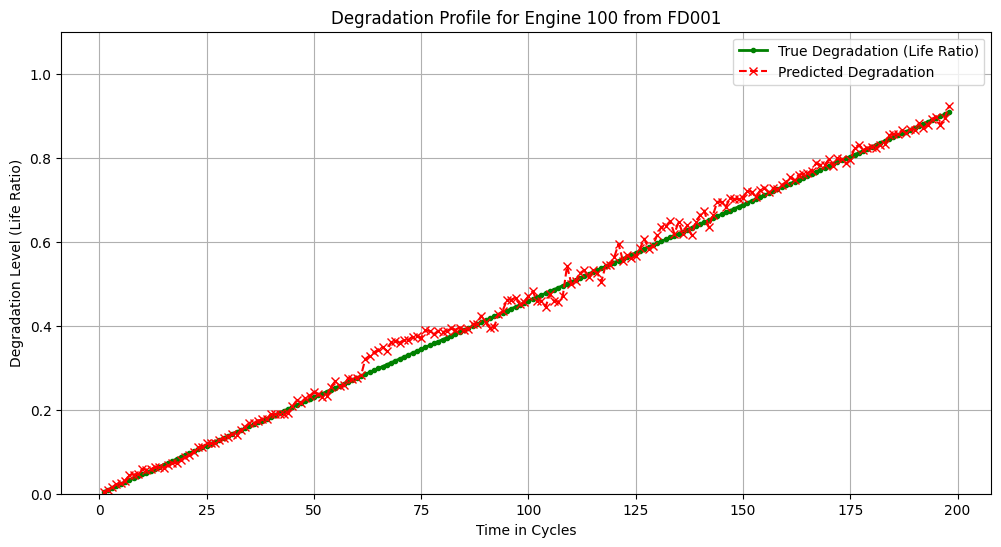

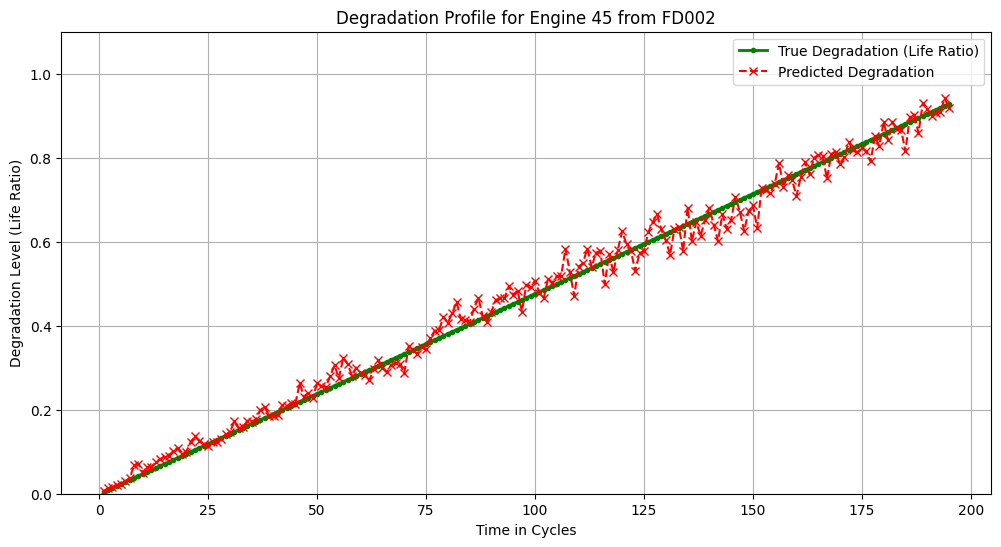

In [9]:
def plot_engine_profile(dataset_id, unit_id, model, test_dataframe):
    """
    Plots the true vs. predicted life ratio for a single, specific engine.
    
    Args:
        dataset_id (str): The dataset of the engine (e.g., 'FD001').
        unit_id (int): The unit number of the engine.
        model: The trained XGBoost model.
        test_dataframe (pd.DataFrame): The full, official test dataframe.
    """
    
    # --- 1. Isolate the data for the specific engine ---
    engine_data = test_dataframe[(test_dataframe['dataset'] == dataset_id) & (test_dataframe['unit_number'] == unit_id)]
    
    if engine_data.empty:
        print(f"No data found for Dataset {dataset_id}, Unit {unit_id}")
        return

    # --- 2. Get the true life ratio and the features for prediction ---
    true_values = engine_data['life_ratio']
    X_engine_test = engine_data[feature_cols] # Use the same feature columns from training

    # --- 3. Get the model's predictions for this engine ---
    pred_values = model.predict(X_engine_test)

    # --- 4. Plotting ---
    plt.figure(figsize=(12, 6))
    
    # Plot the true degradation path
    plt.plot(engine_data['time_in_cycles'], true_values, label='True Degradation (Life Ratio)', color='green', linewidth=2, marker='.')
    
    # Plot the model's predictions
    plt.plot(engine_data['time_in_cycles'], pred_values, label='Predicted Degradation', color='red', linestyle='--', marker='x')
    
    plt.title(f'Degradation Profile for Engine {unit_id} from {dataset_id}')
    plt.xlabel('Time in Cycles')
    plt.ylabel('Degradation Level (Life Ratio)')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.1) # Set y-axis limit to just above 1.0
    plt.show()

# --- HOW TO USE ---
# Choose the dataset and engine you want to see
# Let's look at an engine from the simplest dataset
plot_engine_profile('FD001',100, xgb_model, test_data_official)

# Now let's look at an engine from the most complex dataset
plot_engine_profile('FD002', 45, xgb_model, test_data_official)